<a href="https://colab.research.google.com/github/MrCogito/SpecGan/blob/main/Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generate spectrogram**

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import os
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [18]:
!unzip /content/gdrive/MyDrive/Inzynierka/Models/dogs/dataset/dogs.zip > /dev/null 

# Set parameters


In [57]:
audio_folder = '/content/Dogs'
dataset_tensor_folder = '/content/gdrive/MyDrive/Inzynierka/Models/dogs/dataset'
#audio_trim_folder = '/content/gdrive/MyDrive/Inzynierka/Data_new/audio_trim_folder/'
dataset_tensor = np.empty((0,128,88))
TENSOR_NAME = "tensor_dogs"
TARGET_SIZE = 16000                     
TARGET_SAMPLING_RATE=8000
SPLIT_DURATION = 2          # in seconds
#spectrogram_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_mel_spectrogram_256_8_3.npy')

# Split clips augumentation 

In [24]:
## data aug 
#Split audio clip into smaller pieces
def split_audio_clip(path, duration):
  audio, sr = librosa.load(path)
  audio, index = librosa.effects.trim(audio, top_db = 15) 
  buffer = duration * sr

  samples_total = len(audio)
  samples_wrote = 0
  counter = 1

  while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples 
    if (samples_total - samples_wrote) < (buffer * 2):
      buffer = samples_total - samples_wrote
    block = audio[samples_wrote : (samples_wrote + buffer)]
    out_filename = path + str(counter) + "split.wav"

    sf.write(out_filename, block, sr)
    counter += 1
    samples_wrote += buffer 


In [41]:
def split_clips(folder_path,duration):

  '''
  for root, dirs, files in os.walk(folder_path):
    for name in files:
        print(os.path.join(root, name))     
        split_audio_clip(os.path.join(root, name,), duration)
    for name in dirs:
        print(os.path.join(root, name))
  '''     

  for root, dirs, files in os.walk(folder_path):
    for name in files:
      print(os.path.join(root, name))     
      if not (name.endswith("split.wav")):
        os.remove(os.path.join(root, name,))  


In [44]:
split_clips(audio_folder,SPLIT_DURATION)

/content/dogs/dogs_0556.wav
/content/dogs/dogs_0203.wav
/content/dogs/dogs_0166.wav
/content/dogs/dogs_0522.wav1split.wav
/content/dogs/dogs_0674.wav
/content/dogs/dogs_0050.wav1split.wav
/content/dogs/dogs_0971.wav
/content/dogs/dogs_0206.wav1split.wav
/content/dogs/dogs_0163.wav1split.wav
/content/dogs/dogs_0699.wav
/content/dogs/dogs_0806.wav3split.wav
/content/dogs/dogs_0807.wav1split.wav
/content/dogs/dogs_0016.wav2split.wav
/content/dogs/dogs_0800.wav1split.wav
/content/dogs/dogs_0663.wav
/content/dogs/dogs_0725.wav3split.wav
/content/dogs/dogs_0672.wav
/content/dogs/dogs_0876.wav1split.wav
/content/dogs/dogs_0741.wav
/content/dogs/dogs_0866.wav4split.wav
/content/dogs/dogs_0900.wav
/content/dogs/dogs_0321.wav
/content/dogs/dogs_0689.wav1split.wav
/content/dogs/dogs_0228.wav
/content/dogs/dogs_0692.wav1split.wav
/content/dogs/dogs_0030.wav6split.wav
/content/dogs/dogs_0888.wav1split.wav
/content/dogs/dogs_0020.wav
/content/dogs/dogs_0187.wav1split.wav
/content/dogs/dogs_0663.wav1

# Create mel spectrograms


In [58]:
#Create MEL  - spectrograms

for root, dirs, files in os.walk(audio_folder):
  for name in files:
    print(name)
    if name.endswith("wav"):
      audio_file, sr = librosa.load(os.path.join(root,name))  
      print(sr)                                                                                                        
      #print(audio_file.dtype)
      #audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                          # Trim silnce with threshold equal to 15dB
      audio_file_trim_4k = librosa.resample(audio_file, sr, target_sr = sr)                                            # resample TARGET_SAMPLING_RATE
      audio_fix_length = librosa.util.fix_length(audio_file_trim_4k, 2*sr, axis=- 1)                                   # get same length in all clip, zero padding  
      Spectrogram = librosa.feature.melspectrogram(audio_fix_length, sr=sr, n_fft=2048, hop_length=505, n_mels=128)   #create Mel spectrogram
      S_DB = librosa.power_to_db(Spectrogram, ref=np.max)
      tensor_spectrogram = tf.convert_to_tensor(S_DB)                                                                  # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      #print(tensor_spectrogram.shape) 
      dataset_tensor = tf.concat([dataset_tensor, tensor_spectrogram], 0)
      

np.save(os.path.join(dataset_tensor_folder , TENSOR_NAME), dataset_tensor)
print(dataset_tensor.shape)


Streaming output truncated to the last 5000 lines.
22050
dogs_0786.wav5split.wav
22050
dogs_0971.wav1split.wav
22050
dogs_0872.wav14split.wav
22050
dogs_1014.wav1split.wav
22050
dogs_0636.wav1split.wav
22050
dogs_0481.wav1split.wav
22050
dogs_0003.wav9split.wav
22050
dogs_0465.wav1split.wav
22050
dogs_1049.wav28split.wav
22050
dogs_0849.wav4split.wav
22050
dogs_0828.wav4split.wav
22050
dogs_0159.wav1split.wav
22050
dogs_0023.wav7split.wav
22050
dogs_0500.wav1split.wav
22050
dogs_0036.wav2split.wav
22050
dogs_0439.wav1split.wav
22050
dogs_0572.wav1split.wav
22050
dogs_0409.wav1split.wav
22050
dogs_0416.wav1split.wav
22050
dogs_0275.wav1split.wav
22050
dogs_0590.wav1split.wav
22050
dogs_0030.wav1split.wav
22050
dogs_0851.wav5split.wav
22050
dogs_0293.wav1split.wav
22050
dogs_1026.wav1split.wav
22050
dogs_0823.wav2split.wav
22050
dogs_0820.wav1split.wav
22050
dogs_0872.wav8split.wav
22050
dogs_0843.wav1split.wav
22050
dogs_0868.wav7split.wav
22050
dogs_0937.wav1split.wav
22050
dogs_0892.w

# Create Spectograms


In [ ]:
#Create spectrograms

i=0
for root, dirs, files in os.walk(audio_folder):
  for name in files:
   
    if name.endswith("wav"):
      #print(os.path.join(root,name))
      audio_file, sr = librosa.load(os.path.join(root,name))                                                       
      #print(audio_file.dtype)
      #audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                      # Trim silnce with threshold equal to 15dB
      audio_file_fix_length = librosa.util.fix_length(audio_file, sr*2, axis=- 1)
      print("DURATION: " + str(librosa.get_duration(audio_file_fix_length,sr=22050)))                                  # get same length in all clips  (2s)   
      spectrogram = np.abs(librosa.stft(audio_file_fix_length,n_fft=2046, hop_length=700))                         # create spectrogram.  n_fft size set to 510 to get 256 x n shape of spectrogram  
      tensor_spectrogram = tf.convert_to_tensor(spectrogram)                                                       # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      #print(tensor_spectrogram.shape)
      dataset_tensor = tf.concat([dataset_tensor,tensor_spectrogram], 0)
      print(dataset_tensor.shape) 
      #print(i)
      #i = i+1


np.save(os.path.join(dataset_tensor_folder , TENSOR_NAME), dataset_tensor)


DURATION: 2.0
(1, 1024, 64)
DURATION: 2.0
(2, 1024, 64)
DURATION: 2.0
(3, 1024, 64)
DURATION: 2.0
(4, 1024, 64)
DURATION: 2.0
(5, 1024, 64)
DURATION: 2.0
(6, 1024, 64)
DURATION: 2.0
(7, 1024, 64)
DURATION: 2.0
(8, 1024, 64)
DURATION: 2.0
(9, 1024, 64)
DURATION: 2.0
(10, 1024, 64)
DURATION: 2.0
(11, 1024, 64)
DURATION: 2.0
(12, 1024, 64)
DURATION: 2.0
(13, 1024, 64)
DURATION: 2.0
(14, 1024, 64)
DURATION: 2.0
(15, 1024, 64)
DURATION: 2.0
(16, 1024, 64)
DURATION: 2.0
(17, 1024, 64)
DURATION: 2.0
(18, 1024, 64)
DURATION: 2.0
(19, 1024, 64)
DURATION: 2.0
(20, 1024, 64)
DURATION: 2.0
(21, 1024, 64)
DURATION: 2.0
(22, 1024, 64)
DURATION: 2.0
(23, 1024, 64)
DURATION: 2.0
(24, 1024, 64)
DURATION: 2.0
(25, 1024, 64)
DURATION: 2.0
(26, 1024, 64)
DURATION: 2.0
(27, 1024, 64)
DURATION: 2.0
(28, 1024, 64)
DURATION: 2.0
(29, 1024, 64)
DURATION: 2.0
(30, 1024, 64)
DURATION: 2.0
(31, 1024, 64)
DURATION: 2.0
(32, 1024, 64)
DURATION: 2.0
(33, 1024, 64)
DURATION: 2.0
(34, 1024, 64)
DURATION: 2.0
(35, 1024

## Mel-Spectrograms to audio 


(2, 128, 44)
(44032,)


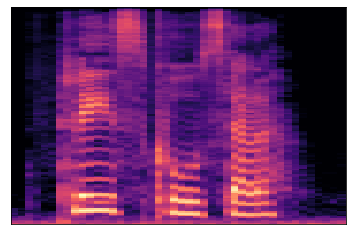

In [ ]:
### REAL 

loaded = np.load('/content/gdrive/MyDrive/Inzynierka/Models/vctk_female/dataset/Female_test.npy')
print(loaded.shape)
#loaded = loaded.reshape(16,256,8)
#loaded = (loaded *80)-80
#S_DB = librosa.power_to_db(S, ref=np.max)
spec_gen = loaded[0]
librosa.display.specshow(spec_gen)
P = librosa.db_to_power(spec_gen, ref=1.0)
S = librosa.feature.inverse.mel_to_stft(P,sr=22050, n_fft=4096)
y = librosa.griffinlim(S)
print(y.shape)
ipd.Audio(y, rate=22050)

# Spectrograms to audio 


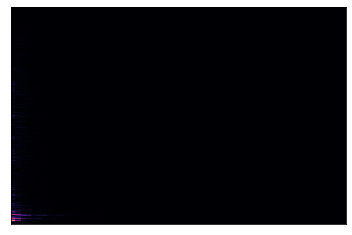

In [ ]:
### REAL

loaded_real = np.load('/content/gdrive/MyDrive/Inzynierka/Models/drums/dataset/tensor_snare.npy')

#print(loaded_real.shape)
#print(loaded_real.dtype)
#print(loaded_real.size)
spec = loaded_real[1]
#print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

#print(audio.shape)
#print("DURATION: " + str(librosa.get_duration(audio,sr=22050)))
ipd.Audio(audio, rate=22050)
#print(np.amax(loaded_real))
#print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)


(16, 1024, 64, 1)
float32
(1024, 64)
0.80924517
1.1146195e-37


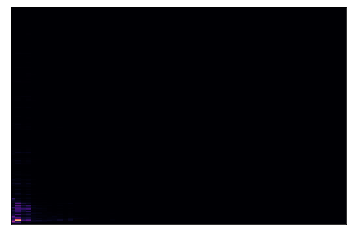

In [ ]:
### GENERATED

loaded_real = np.load('/content/gdrive/MyDrive/Inzynierka/Models/drums/generated/snare/snare500.npy')
print(loaded_real.shape)
print(loaded_real.dtype)
loaded_real = np.squeeze(loaded_real)

spec = loaded_real[1]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)


(1024, 64)
0.80924517
1.1146195e-37


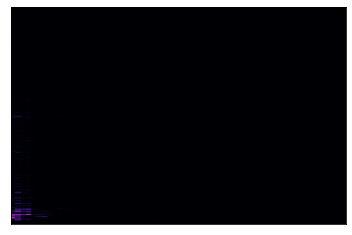

In [ ]:
spec = loaded_real[2]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)

(1024, 64)
0.80924517
1.1146195e-37


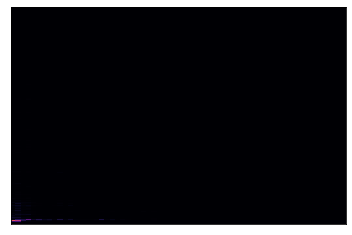

In [ ]:
spec = loaded_real[13]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)

(1024, 64)
0.80924517
1.1146195e-37


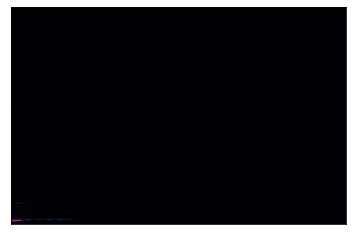

In [ ]:
spec = loaded_real[5]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)

(1024, 64)
0.80924517
1.1146195e-37


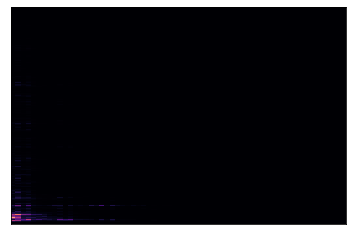

In [ ]:
spec = loaded_real[8]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)

(1024, 64)
0.80924517
1.1146195e-37


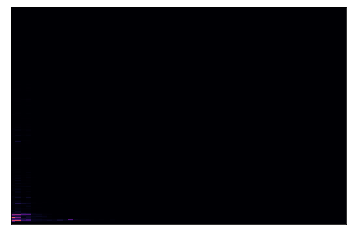

In [ ]:
spec = loaded_real[9]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

print(np.amax(loaded_real))
print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)